# Correcting for non-responses in appliance hour survey data

In my 2016-03-02 notebook, I showed that there are households that said they own an appliance but did not respond to questions about how many hours they used these appliances.


We want to be sure that we are extrapolating correctly from our
appliance survey to the whole population.  For example if null responses
for the hours used by an appliance mean the household doesn't use that
appliance, then we should count that as a zero and the mean over all
households in the population will be correct.  If however, the household
owns the appliance and doesn't answer the hours survey question, then we
should assign that person the mean of the other responses.

| TV yes/no | TV hours |
| -         | -        |
| 1         | 6        |
| 1         | null     |
| 0         | 6        |
| 0         | null     |

The second line is important to check for and the third line should not
happen.  The third line shouldn't occur because the survey uses the
`selected()` command in the relevant column so that only respondents
owning the appropriate appliance are asked the question.  This is per
appliance.

One next step is to create a calculation that accounts for this
discrepancy and makes a comparison of its result.


For determining the fraction of households possessing an appliance, we include surveys that have 


TODO:

- what fraction of households surveyed posess each appliance
- what is the average hours per week for each appliance type?
- what is the average hours per week of each appliance type use across the survey?



In [54]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

from drs_sentani import get_survey
import pandas as pd
survey = get_survey()
import pysentani as sti

survey['access_type'] = sti.access_type(survey)

In [3]:
# filter data for appliance ownership
appliance_list = ['TV', 'fridge', 'radio', 'fan', 'rice_cooker', 'lighting']
columns = ['app_now/{}'.format(a) for a in appliance_list]
columns.append('access_type')
appliance_data = survey[columns]


# the mean function disregards null values
appliance_data.groupby('access_type').mean()
gbad = appliance_data.groupby('access_type').mean()
gbad['access_type'] = gbad.index
gbad

,app_now/TV,app_now/fridge,app_now/radio,app_now/fan,app_now/rice_cooker,app_now/lighting,access_type
access_type,,,,,,,
PLN_grid,0.815141,0.329225,0.301056,0.176056,0.276408,0.931338,PLN_grid
PLN_microgrid,0.810127,0.037975,0.278481,0.025316,0.012658,0.949367,PLN_microgrid
community_microgrid,0.923077,0.019231,0.500000,0.096154,0.134615,0.865385,community_microgrid
no_access,0.797665,0.015564,0.431907,0.081712,0.031128,0.883268,no_access


In [4]:
# convert table of mean values to tidy format and plot
columns = ['app_now/{}'.format(a) for a in appliance_list]
mgbad = pd.melt(gbad, value_vars=columns, id_vars=['access_type'])
mgbad.head()

,access_type,variable,value
0,PLN_grid,app_now/TV,0.815141
1,PLN_microgrid,app_now/TV,0.810127
2,community_microgrid,app_now/TV,0.923077
3,no_access,app_now/TV,0.797665
4,PLN_grid,app_now/fridge,0.329225


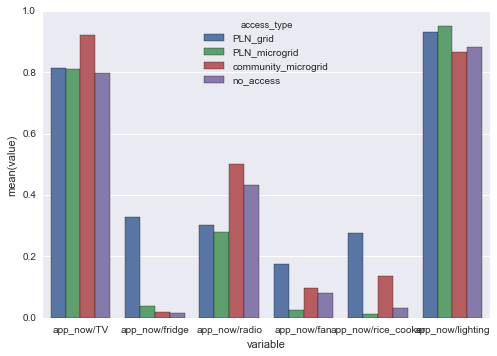

In [5]:
sns.barplot(data=mgbad, hue=mgbad['access_type'], y=mgbad['value'], x=mgbad['variable'])

# Next steps

Perform a similar analysis for hours per week and consider non-responses correctly.  We also need to filter out hours and weekly responses that don't make sense.  If hours per day is over 24 make null.  If use per week is greater than 7 make null.  

In [31]:
for app in ['TV', 'radio', 'fridge']:
    #app = 'TV'
    data_columns = [a.format(app) for a in ['app_now/{}', 'app_{}_hrs', 'app_{}_per_wk']]
    data_maps = {'own':'app_now/{}',
                    'hours_per_use':'app_{}_hrs', 
                    'use_per_week':'app_{}_per_wk'}
    data_columns = {k: v.format(app) for k, v in data_maps.items()}

    label_columns = ['village_name', 'access_type']

    data_columns.values()

    app_data = survey[list(data_columns.values()) + label_columns]

    app_owners = app_data[app_data[data_columns['own']]==1]

    weekly_hr_col = 'weekly_{}_hrs'.format(app)
    app_owners[weekly_hr_col] = app_owners[data_columns['hours_per_use']] * app_owners[data_columns['use_per_week']]    
    
    print(app_owners[weekly_hr_col].describe())

count    810.000000
mean      46.744444
std       37.695713
min        0.000000
25%       21.000000
50%       42.000000
75%       56.000000
max      576.000000
Name: weekly_TV_hrs, dtype: float64
count    340.000000
mean      25.691176
std       40.385698
min        0.000000
25%        8.000000
50%       14.000000
75%       35.000000
max      576.000000
Name: weekly_radio_hrs, dtype: float64
count       193.000000
mean        788.735751
std        8625.967258
min           0.000000
25%         168.000000
50%         168.000000
75%         168.000000
max      120000.000000
Name: weekly_fridge_hrs, dtype: float64


/Users/dsoto/anaconda/envs/sotolab/lib/python3.4/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [27]:
app = 'TV'
data_columns = [a.format(app) for a in ['app_now/{}', 'app_{}_hrs', 'app_{}_per_wk']]
data_maps = {'own':'app_now/{}',
                'hours_per_use':'app_{}_hrs', 
                'use_per_week':'app_{}_per_wk'}
data_columns = {k: v.format(app) for k, v in data_maps.items()}

label_columns = ['village_name', 'access_type']

data_columns.values()

app_data = survey[list(data_columns.values()) + label_columns]

app_owners = app_data[app_data[data_columns['own']]==1]
app_owners.fillna(0, inplace=True)

weekly_hr_col = 'weekly_{}_hrs'.format(app)
app_owners[weekly_hr_col] = app_owners[data_columns['hours_per_use']] * app_owners[data_columns['use_per_week']]   
app_owners[weekly_hr_col].describe()

/Users/dsoto/anaconda/envs/sotolab/lib/python3.4/site-packages/pandas/core/frame.py:2705: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  **kwargs)
/Users/dsoto/anaconda/envs/sotolab/lib/python3.4/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


count    844.000000
mean      44.861374
std       38.055662
min        0.000000
25%       21.000000
50%       42.000000
75%       56.000000
max      576.000000
Name: weekly_TV_hrs, dtype: float64

In [65]:
# testing a method for filtering bad responses

import numpy as np
survey_copy = survey.copy(deep=True)

for app in ['TV', 'radio', 'fridge']:
    #app = 'TV'
    wk_col = 'app_{}_per_wk'.format(app)
    hr_col = 'app_{}_hrs'.format(app)
    energy_col = 'daily_{}_energy'.format(app)
    weekly_hr_col = 'weekly_{}_hrs'.format(app)
    print(survey_copy[hr_col].describe())
    survey_copy[hr_col] = survey_copy[hr_col].where(survey_copy[hr_col].isnull() | (survey_copy[hr_col] <= 24), 24)
    print(survey_copy[hr_col].describe())
    print(survey_copy[wk_col].describe())
    survey_copy[wk_col] = survey_copy[wk_col].where(survey_copy[wk_col].isnull() | (survey_copy[wk_col] <= 7), 7)
    print(survey_copy[wk_col].describe())


count    811.000000
mean       6.903822
std        4.524078
min        0.000000
25%        4.000000
50%        6.000000
75%        8.000000
max       24.000000
Name: app_TV_hrs, dtype: float64
count    811.000000
mean       6.903822
std        4.524078
min        0.000000
25%        4.000000
50%        6.000000
75%        8.000000
max       24.000000
Name: app_TV_hrs, dtype: float64
count    810.000000
mean       6.488889
std        1.529439
min        0.000000
25%        7.000000
50%        7.000000
75%        7.000000
max       24.000000
Name: app_TV_per_wk, dtype: float64
count    810.000000
mean       6.449383
std        1.360953
min        0.000000
25%        7.000000
50%        7.000000
75%        7.000000
max        7.000000
Name: app_TV_per_wk, dtype: float64
count    341.000000
mean       4.108504
std        4.031124
min        0.000000
25%        2.000000
50%        3.000000
75%        5.000000
max       24.000000
Name: app_radio_hrs, dtype: float64
count    341.000000
mean  